## Learning outcomes
1. Image histogram: distribution grayscale value
2. Enhance contrast: scalar multiplication on image, histogram equalization and its variant called CLAHE.
3. Thresholding: global thresholding and otsu thresholding
4. Morphological operations (limit our discussion on binary image)
5. Color spaces: HSV color space used to perform color based segmentation.

## Setup

In [1]:
import sys
assert sys.version_info >=(3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Image histogram

In [2]:
img = cv.imread("images/lena.jfif")
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

In [3]:
# There are 2 ways to compute histogram
%timeit hist = cv.calcHist([gray], [0], None, [256], [0, 256])
%timeit hist, _ = np.histogram(gray.flatten(), 256)

34.5 µs ± 633 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
963 µs ± 257 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


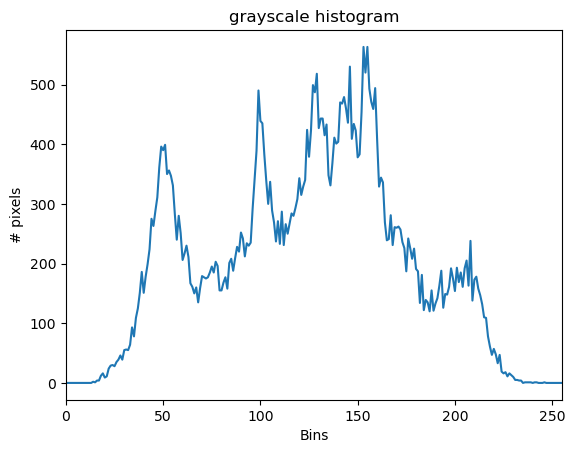

In [4]:
hist = cv.calcHist([gray], [0], None, [256], [0, 256])

plt.figure()
plt.title("grayscale histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.plot(hist)
plt.xlim([0, 255])
plt.show()

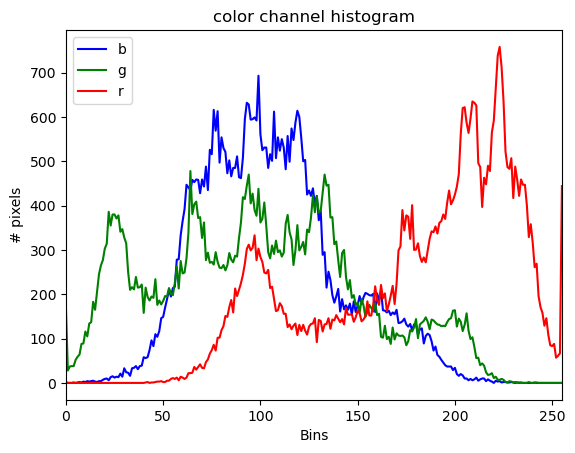

In [5]:
# get the histogram for every channel
channels = cv.split(img)
colors = ("b", "g", "r")

plt.figure()
plt.title("color channel histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")

for ch, color in zip(channels, colors):
    hist = cv.calcHist([ch], [0], None, [256], [0, 256])
    plt.plot(hist, color=color, label = color)
    
plt.xlim([0, 255])
plt.legend()
plt.show()

In [6]:
img = cv.imread("images/low_contrast_img.jfif", 0)
show_img("low contrast", img)

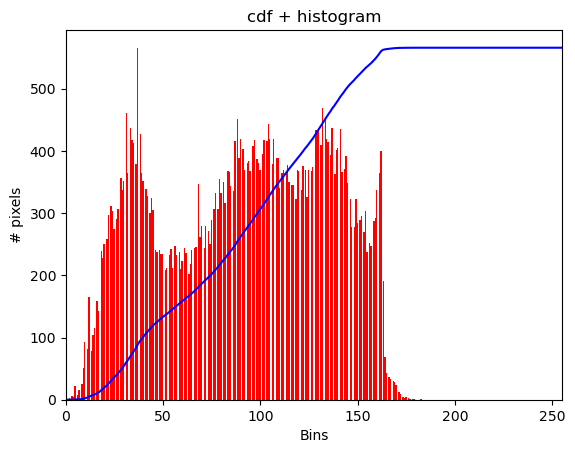

In [7]:
# histogram for this image
hist = cv.calcHist([img], [0], None, [256], [0, 256])

# cdf
cdf = hist.cumsum()
cdf_norm = cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(img.flatten(), 256, color="r")
plt.title("cdf + histogram")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.xlim([0,255])
plt.show()

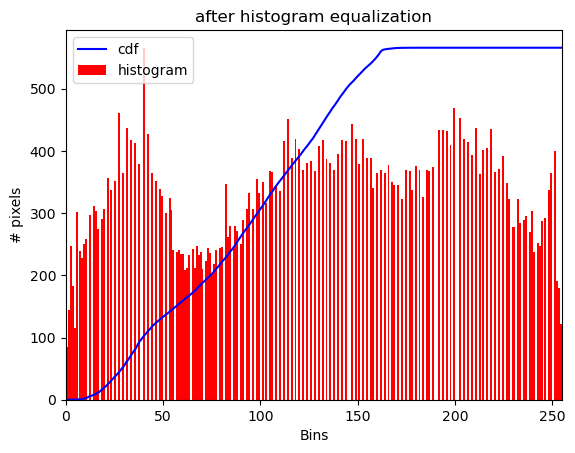

In [8]:
# histogram equalization
eq = cv.equalizeHist(img)
cdf = hist.cumsum()
cdf_norm= cdf * hist.max() / cdf.max()

plt.figure()
plt.plot(cdf_norm, color="b")
plt.hist(eq.flatten(), 256, color="r")
plt.title("after histogram equalization")
plt.xlabel("Bins")
plt.ylabel("# pixels")
plt.legend(("cdf","histogram"))
plt.xlim([0,255])
plt.show()

In [9]:
# CLANE
img = cv.imread("images/dog1.jfif", 0)

# equalization
eq = cv.equalizeHist(img)
# CLAHE
clahe = cv.createCLAHE(clipLimit=4, tileGridSize=(8, 8))
dst = clahe.apply(img)

cv.imshow("original", img)
cv.imshow("equalization", eq)
show_img("dst", dst)
cv.waitKey(0)
cv.destroyAllWindows()

## Thresholding

In [10]:
# simple global thresholding
# different types of thresholding
[i for i in dir(cv) if i.startswith("THRESH")]

['THRESH_BINARY',
 'THRESH_BINARY_INV',
 'THRESH_MASK',
 'THRESH_OTSU',
 'THRESH_TOZERO',
 'THRESH_TOZERO_INV',
 'THRESH_TRIANGLE',
 'THRESH_TRUNC']

In [11]:
img = np.fromfunction(lambda i, j: j, (50, 256), dtype = np.uint8)

def trackbar(x):
    _, img1 = cv.threshold(img, x, 255, cv.THRESH_BINARY)
    _, img2 = cv.threshold(img, x, 255, cv.THRESH_BINARY_INV)
    _, img3 = cv.threshold(img, x, 255, cv.THRESH_TRUNC)
    _, img4 = cv.threshold(img, x, 255, cv.THRESH_TOZERO)
    _, img5 = cv.threshold(img, x, 255, cv.THRESH_TOZERO_INV)
    
    cv.imshow("window", np.vstack((img, img2, img3, img4, img5)))
    
cv.namedWindow("window")
cv.createTrackbar("threshold", "window", 100, 255, trackbar)

cv.waitKey(0)
cv.destroyAllWindows()

## Simple global threshold vs Otsu thresholding
- Otsu thresholding better

In [12]:
img = cv.imread("images/noisy.jfif", 0)
show_img("noisy", img)

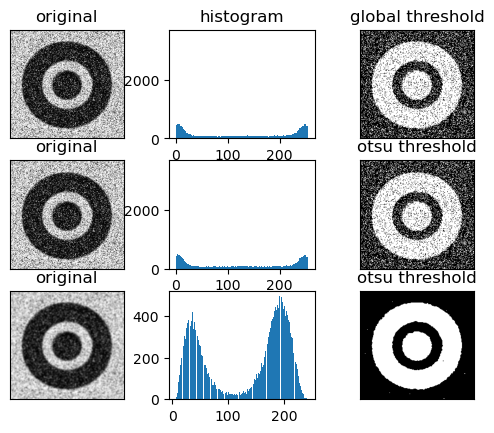

In [13]:
# apply 3 approaches: 1. global threshold, 2 otsu threshold, 3. blurring + otsu

#1:
th1 = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)[1]

#2:
th2 = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

#3:
blur = cv.GaussianBlur(img, (5, 5), 0)
th3 = cv.threshold(blur, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1]

imgs = [img, 0, th1,
       img, 0, th2,
       blur, 0, th3]

titles = ("original", "histogram", "global threshold",
         "original", "", "otsu threshold",
         "blue", "", "otsu threshold")

for i in range(3):
    plt.subplot(3, 3, 3*i+1), plt_img(imgs[3*i], title=titles[3*1])
    plt.subplot(3, 3, 3*i+2), plt.hist(imgs[3*i].flatten(), 256), plt.title(titles[3*i+1])
    plt.subplot(3, 3, 3*i+3), plt_img(imgs[3*i+2], title = titles[3*i+2])
    
plt.show() 

## Morphological operations

In [14]:
# kernel
kernel = np.ones((3, 3), np.uint8)

# erosion
erosion = cv.erode(th3, kernel, iterations=1)

# combined
img_combined = np.hstack((th3, erosion))

show_img("erosion", img_combined)

In [15]:
# trackbar: function and while loop
def nothing(x):
    pass

wn = "window"
cv.namedWindow(wn)
cv.createTrackbar("size", wn, 3, 10, nothing)
cv.createTrackbar("iter", wn, 3, 10, nothing)

while (1):
    # retrive the size and # iteration
    size = cv.getTrackbarPos("size", wn)
    if size < 3:
        size = 3;
        
    iteration = cv.getTrackbarPos("iter", wn)
    if iteration < 1:
        iteration = 1
        
    kernel = np.ones((size, size), dtype = np.uint8)
    #closing 
    closing = cv.morphologyEx(th3, cv.MORPH_OPEN, kernel, iterations=iteration)
    
    cv.imshow(wn, closing)
    k =cv.waitKey(1) & 0xFF
    if k==27:
        break
        
cv.destroyAllWindows()

In [16]:
cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

## Color spaces
- RGB / BGR (prevalent image formats)
- HSV (hue, saturation, value)
    * hue encodes color (angular, 0-359). In openCV, 0-179
    * saturation implies color purity
    * value: brightness. 0 is dark.
- L\*a\*b:
    - L denotes brightness / luminance while a and b are color channels.
    - perceptual uniformity

In [20]:
# sharpen image
img = cv.imread("images/lena.jfif")

img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

l, a, b = cv.split(img_lab)

# process just the l channel 
# sharpen
kernel = np.array([[0, -1, 0],[-1, 5, -1], [0, -1, 0]])
l_sharpen = cv.filter2D(l, -1, kernel)

# merge
sharpen = cv.merge((l_sharpen, a, b))

#change to bgr
sharpen = cv.cvtColor(sharpen, cv.COLOR_Lab2BGR)

cv.imshow("original", img)
show_img("sharpen", sharpen)

## Demo on color based segmentation

In [62]:
img = cv.imread("images/color_space/pant.jfif")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

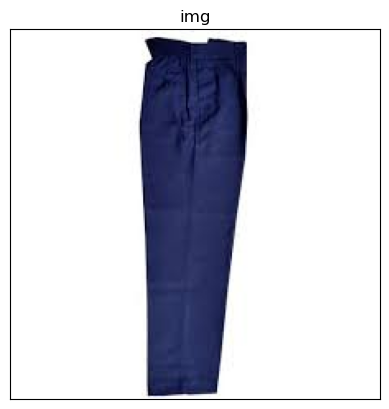

In [63]:
plt_img(img, "img")

In [64]:
## import depencies
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

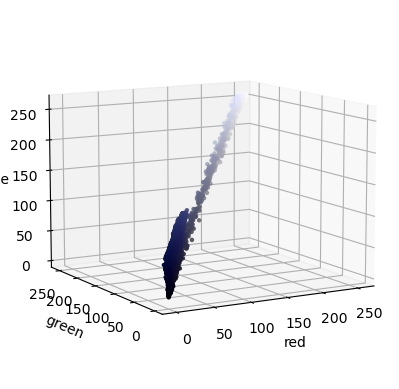

In [65]:
# split the image into seperate channels
r, g, b = cv.split(img)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection = "3d")

# pixel colors ready as argument for scatter plot
pixel_colors = img.reshape((-1, 3))
norm = colors.Normalize()
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.ravel(), g.ravel(), b.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=240)
axis.set_xlabel("red")
axis.set_ylabel("green")
axis.set_zlabel("blue")
plt.show()

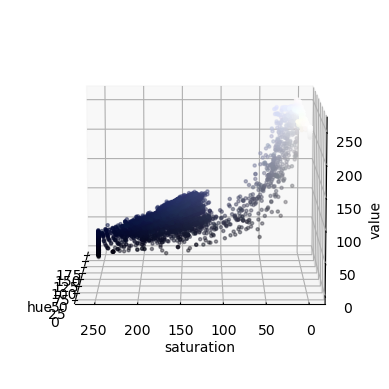

In [66]:
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)

h, s, v = cv.split(img_hsv)
# set up 3D figure
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection = "3d")

axis.scatter(h.ravel(), s.ravel(), v.ravel(),
            facecolors = pixel_colors, marker=".")
axis.view_init(elev=10, azim=180)
axis.set_xlabel("hue")
axis.set_ylabel("saturation")
axis.set_zlabel("value")
plt.show()

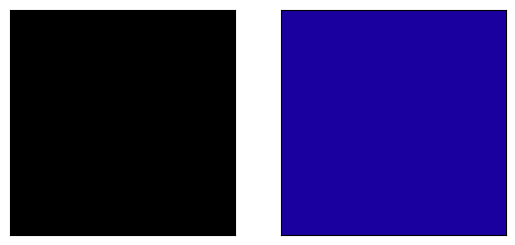

In [67]:
blue_low = (85, 90, 0)
blue_high = (125, 255, 160)

square1 = np.full((10, 10, 3), blue_low, dtype = np.uint8)
square2 = np.full((10, 10, 3), blue_high, dtype = np.uint8)

plt.subplot(121), plt_img(cv.cvtColor(square1, cv.COLOR_HSV2RGB))
plt.subplot(122), plt_img(cv.cvtColor(square2, cv.COLOR_HSV2RGB))
plt.show()

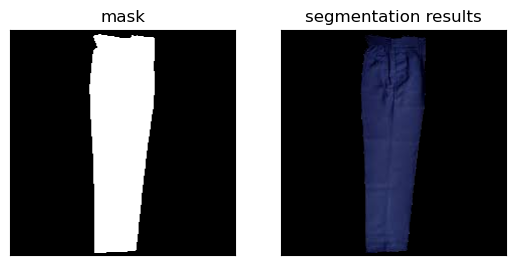

In [68]:
# color based segmentation
mask = cv.inRange(img_hsv, blue_low, blue_high)
res = cv.bitwise_and(img, img, mask=mask)

plt.subplot(121), plt_img(mask, title="mask")
plt.subplot(122), plt_img(res, title="segmentation results")
plt.show()

## Exercise

In [70]:
def color_seg(img, color_low, color_high, smooth=True):
    """Args:
    img: sourcr image
    color_low an color_high are tuple of colors
    smooth is boolean (blurring or not)"""
    ori_img = img.copy()
    if smooth:
        img = cv.GaussianBlur(img, (5, 5), 0)
        
    # change from RGB to HSV
    img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
    
    # mask
    mask = cv.inRange(img_hsv, color_low, color_high)
    mask = cv.erode(mask, None, iterations=2)
    mask = cv.dilate(mask, None, iterations=2)
    
    return cv.bitwise_and(ori_img, ori_img, mask=mask)

imgs = []

for i in range(1, 6):
    img = cv.imread(cv.samples.findFile(f"images/color_space/pant{i}.jfif"))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    imgs.append(img)
    
# perform color segmentation
res = [color_seg(im, blue_low, blue_high) for im in imgs]

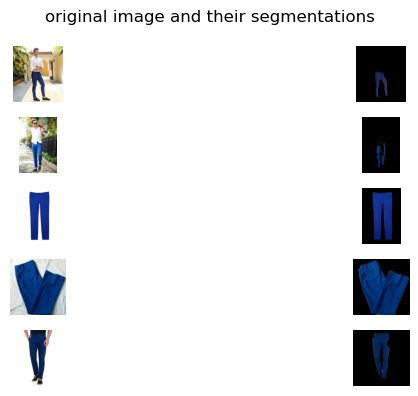

In [72]:
fig, ax = plt.subplots(5, 2, figsize=(10, 4))

for i in range(5):
    ax[i][0].imshow(imgs[i])
    ax[i][0].axis("off")
    ax[i][1].imshow(res[i])
    ax[i][1].axis("off")
    
fig.suptitle("original image and their segmentations")
plt.tight_layout()
plt.show()